<a href="https://colab.research.google.com/github/crew-guy/ml-with-tensorflow/blob/main/tf_transfer_learn_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with Tensorflow - Fine tuning

In the previous sections, we have learnt the basics of transfer learning & in this one, we shall explore another type of the same - "Fine Tuning"

In [40]:
!nvidia-smi

Mon Dec  5 17:03:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   2872MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In the previous notebooks, we have created a bunch of helper functions that we can import via scripts. Instead of re-writing them, we can import them

So it's a good idea to put functions you'll want to use again in a script that you can download & import into your notebooks or elsewhere.


We've done this for some functions we're previously used here - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [41]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/cac2f14a63f23753d9ce56dfb695c10bc03e58e1/extras/helper_functions.py

--2022-12-05 17:03:51--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/cac2f14a63f23753d9ce56dfb695c10bc03e58e1/extras/helper_functions.py
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘helper_functions.py.1’

helper_functions.py     [ <=>                ] 264.57K  --.-KB/s    in 0.03s   

2022-12-05 17:03:51 (8.41 MB/s) - ‘helper_functions.py.1’ saved [270916]



In [42]:
# Import helper functions that we'll use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note**: If you're running this notebook in Google Collab & your runtimee gets disconnected, you gotta refetch the helper_functions.py file by rerunning the script

## Let's get some data

We're going to use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food)

Reference link - https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [43]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2022-12-05 17:03:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 173.194.202.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   206MB/s    in 0.8s    

2022-12-05 17:03:52 (206 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [44]:
unzip_data('10_food_classes_10_percent.zip')

In [45]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [46]:
# Create train & test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [47]:
import tensorflow as tf

IMAGE_SHAPE = (224,224)
BATCH_SIZE= 32

train_data = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [48]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [49]:
# Check out class names of our training data
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [50]:
# See and example of a batch of data
for images, labels in train_data.take(1):
    print(images, labels)

tf.Tensor(
[[[[2.93418369e+01 5.56989784e+01 8.16683655e+01]
   [2.06428566e+01 4.70000000e+01 7.15204086e+01]
   [8.53571415e+00 3.33265305e+01 5.58979607e+01]
   ...
   [3.98520050e+01 8.42805328e+01 1.09494797e+02]
   [2.79540596e+01 6.99540634e+01 9.49540634e+01]
   [3.42195702e+01 7.42195663e+01 1.00219566e+02]]

  [[3.05969391e+01 6.39540825e+01 9.60000000e+01]
   [3.19132633e+01 6.32040787e+01 9.24285660e+01]
   [2.15867329e+01 5.11734695e+01 7.76989822e+01]
   ...
   [4.61989594e+01 9.06274872e+01 1.17413223e+02]
   [5.01377678e+01 9.21377640e+01 1.17137764e+02]
   [4.88570366e+01 8.88570404e+01 1.14857040e+02]]

  [[3.11938763e+01 7.31224442e+01 1.13913261e+02]
   [2.61530609e+01 6.66683655e+01 1.03525505e+02]
   [2.75051022e+01 6.40050964e+01 9.81683655e+01]
   ...
   [4.66173630e+01 9.10458908e+01 1.17831627e+02]
   [5.02142868e+01 9.14285736e+01 1.18785713e+02]
   [5.03418121e+01 8.95560989e+01 1.17913239e+02]]

  ...

  [[1.34857147e+02 1.45642853e+02 1.68285736e+02]
   [1

## Building a model using tf.keras.applications

![Model approach](https://testbucket1841.s3.ap-south-1.amazonaws.com/tf-ml-course-udemy/tf-fine-tune.png)

![Keras Functional vs Sequential](https://testbucket1841.s3.ap-south-1.amazonaws.com/tf-ml-course-udemy/keras-func.png)

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API


The Sequential API is straightforward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional


This process happens in the following 10 steps:

1. Create the base model using tf.keras.applications. Pass `include_top` parameter boolean value to determine whether you want to use the same output classes as the pretrained model or not
2. Freeze the layers that you want to retain the weights for
3. Create the input layer
4. Need to rescale values in input layer if the model is ResNet (no need to rescale for EfficientNet)
5. Create a layer using base model & inputs
6. Add a Global Pooling layer
7. Create the output layer
8. Combine all layers into one model
9. Compile the model
10. Fit the model

In [51]:
# 1. Creating a base model using tf.keras.applications. We don't want to use the pre-trained model's output classes and hence we pass `include_top` as False

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)


# 2. Freeze the weights learnt
base_model.trainable = False

# 3. Create an input layer 
inputs = tf.keras.Input(shape=IMAGE_SHAPE+(3,), name="input_layer")

# 4. Create 1 layer using base_model & inputs
x = base_model(inputs)
print(f"Shape after adding inputs to base_model: {x.shape}")


# 5. Rescale created layer if using ResNet Model
# x = tf.keras.layers.experimental.preprocessing.Rescaling(
#     1./255
# )

# 6. Create a global pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2d_layer")(x)
print(f"Shape after global pooling: {x.shape}")

# 7. Create an output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine all layers into 1 model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"]
)

# 10. Fit the model
history_0 = model_0.fit(
    train_data,
    epochs=5,
    steps_per_epoch= len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks=[create_tensorboard_callback("transfer_learning","feature_extract_model_0")]
)

Shape after adding inputs to base_model: (None, 7, 7, 1280)
Shape after global pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/feature_extract_model_0/20221205-170357
Epoch 1/5
24/24 [==============================] - 19s 580ms/step - loss: 1.8565 - accuracy: 0.4147 - val_loss: 1.3015 - val_accuracy: 0.7452
Epoch 2/5
24/24 [==============================] - 8s 327ms/step - loss: 1.0745 - accuracy: 0.7800 - val_loss: 0.8638 - val_accuracy: 0.8212
Epoch 3/5
24/24 [==============================] - 8s 327ms/step - loss: 0.7727 - accuracy: 0.8280 - val_loss: 0.6970 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 8s 331ms/step - loss: 0.6264 - accuracy: 0.8613 - val_loss: 0.6051 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 8s 325ms/step - loss: 0.5319 - accuracy: 0.8893 - val_loss: 0.5521 - val_accuracy: 0.8592


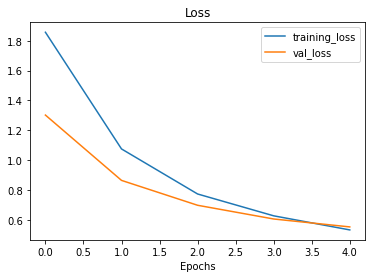

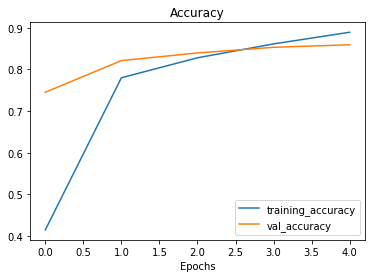

In [52]:
plot_loss_curves(history_0)

In [53]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 tf.math.truediv_3
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [54]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                   

In [55]:
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d_l  (None, 1280)             0         
 ayer (GlobalAveragePooling2                                     
 D)                                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model


Understanding what `GlobalAveragePooling2D` layer really does

When we simply create a layer using `base_model` and inputs, we get a tensor of shape (None, 7, 7, 1280).

However, once we pass this through the `GlobalAveragePooling2D` layer, it reduces the dimensions of this data & transforms it into a tensor of shape (None, 1280)

Under the hood, `GlobalAveragePooling2D` is actually just calculating & returning the mean values of the tensor along the middle 2 axis (i.e. 1st and 2nd axis since python & tf are 0-indexed)

Let's understand this better through an example


In [56]:
tf.random.set_seed(42)
input_shape= (1,4,4,3)

input_tensor = tf.random.normal(input_shape)
print(f"Shape of the input tensor: {input_tensor.shape}")

gap_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape of global average pooling tensor is: {gap_tensor.shape}")

gap_tensor, input_tensor

Shape of the input tensor: (1, 4, 4, 3)
Shape of global average pooling tensor is: (1, 3)


(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
 array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
          [-1.4075519 , -2.3880599 , -1.0392479 ],
          [-0.5573232 ,  0.539707  ,  1.6994323 ],
          [ 0.28893656, -1.5066116 , -0.2645474 ]],
 
         [[-0.59722406, -1.9171132 , -0.62044144],
          [ 0.8504023 , -0.40604794, -3.0258412 ],
          [ 0.9058464 ,  0.29855987, -0.22561555],
          [-0.7616443 , -1.8917141 , -0.93847126]],
 
         [[ 0.77852213, -0.47338897,  0.97772694],
          [ 0.24694404,  0.20573747, -0.5256233 ],
          [ 0.32410017,  0.02545409, -0.10638497],
          [-0.6369475 ,  1.1603122 ,  0.2507359 ]],
 
         [[-0.41728503,  0.4012578 , -1.4145443 ],
          [-0.5931857 , -1.6617213 ,  0.33567193],
          [ 0.10815629,  0.23479682, -0.56668764],
          [-0.35819843,  0.88698614,  0.52744764]]]], dty

In [57]:
# As we can see the .reduce_mean method returns the exact same result as GlobalAveragePooling2D

tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [58]:
gmp_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"Shape of global max pooled 2d tensor: {gmp_tensor.shape}")

input_tensor, gmp_tensor

Shape of global max pooled 2d tensor: (1, 3)


(<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
 array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
          [-1.4075519 , -2.3880599 , -1.0392479 ],
          [-0.5573232 ,  0.539707  ,  1.6994323 ],
          [ 0.28893656, -1.5066116 , -0.2645474 ]],
 
         [[-0.59722406, -1.9171132 , -0.62044144],
          [ 0.8504023 , -0.40604794, -3.0258412 ],
          [ 0.9058464 ,  0.29855987, -0.22561555],
          [-0.7616443 , -1.8917141 , -0.93847126]],
 
         [[ 0.77852213, -0.47338897,  0.97772694],
          [ 0.24694404,  0.20573747, -0.5256233 ],
          [ 0.32410017,  0.02545409, -0.10638497],
          [-0.6369475 ,  1.1603122 ,  0.2507359 ]],
 
         [[-0.41728503,  0.4012578 , -1.4145443 ],
          [-0.5931857 , -1.6617213 ,  0.33567193],
          [ 0.10815629,  0.23479682, -0.56668764],
          [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=flo

> 🔑 **Note** : A feature vector is the learned representation of the input 
data (a compressed form of the input data based on how the model sees it)


![Feature vector](https://testbucket1841.s3.ap-south-1.amazonaws.com/tf-ml-course-udemy/feature-vector.png)

## Running a series of transfer learning experiments

We've seen the amazing power of transfer learning with 10% of the training data. Let's now study what happens when we try different flavors of transfer learning with different available % of data

1. `model_1` : Train using *feature extraction* on 1% of the training data along with data augmentation
2. `model_2` : Train using *feature extraction* on 10% of the training data along with data augmentation
3. `model_3` : Train using *fine tuning* on 10% of the training data along with data augmentation
4. `model_4` : Train using *fine tuning* on 100% of the training data along with data augmentation

> 🔑 **Note:** For all the above models, the validation test data set will be kept the same so that they all have the same kind of evaluation metrics


#### Building `model_1`

##### Downloading & preprocessing the data

In [66]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-12-05 18:02:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   200MB/s    in 0.6s    

2022-12-05 18:02:48 (200 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [67]:
import zipfile

file = zipfile.ZipFile("10_food_classes_1_percent.zip")
file.extractall()
file.close()

In [68]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_1_percent"):
    print(f'There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}')

There are 2 directories and 0 files in 10_food_classes_1_percent
There are 10 directories and 0 files in 10_food_classes_1_percent/train
There are 0 directories and 7 files in 10_food_classes_1_percent/train/ramen
There are 0 directories and 7 files in 10_food_classes_1_percent/train/sushi
There are 0 directories and 7 files in 10_food_classes_1_percent/train/chicken_curry
There are 0 directories and 7 files in 10_food_classes_1_percent/train/chicken_wings
There are 0 directories and 7 files in 10_food_classes_1_percent/train/pizza
There are 0 directories and 7 files in 10_food_classes_1_percent/train/hamburger
There are 0 directories and 7 files in 10_food_classes_1_percent/train/grilled_salmon
There are 0 directories and 7 files in 10_food_classes_1_percent/train/ice_cream
There are 0 directories and 7 files in 10_food_classes_1_percent/train/fried_rice
There are 0 directories and 7 files in 10_food_classes_1_percent/train/steak
There are 10 directories and 0 files in 10_food_classes

In [69]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [70]:
IMAGE_SHAPE

(224, 224)

In [73]:
### Creating the data loaders
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

test_data_1_percent = tf.keras.utils.image_dataset_from_directory(
    test_dir_1_percent,
    label_mode="categorical",
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into model (TensorFlow 2.2 onwards)

To add data augmentation right into our models, we can use the layers inside:
- `tf.keras.layers.experimental.preprocessing()`


Benefits of data augmentation are:
* Data augmentation is done over the GPU so it's a lot faster & efficient
* Data augmentation happens only during training & hence the entire model can be effectively modularized & used elsewhere without any data inconsistency issues

For a further list of benefits of data augmentation, refer official docs - https://www.tensorflow.org/guide/keras/preprocessing_layers

![Image for data aug](https://testbucket1841.s3.ap-south-1.amazonaws.com/tf-ml-course-udemy/data_aug.png)

In [81]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescale(1./255) # Required only for ResNet50v2 models as rescaling is inbuilt in EfficientNet models
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name="data_augmentation")

<ipython-input-91-e8a1d1d81f44>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)


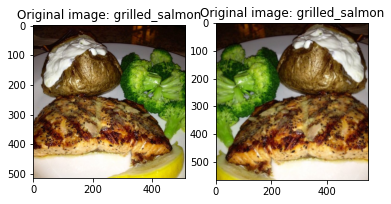

In [91]:
# View a random image & compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_img_path = target_dir + "/" + random_image


img = mpimg.imread(random_img_path)

plt.subplot(1,2,1)
plt.title(f"Original image: {target_class}")
plt.imshow(img)


plt.subplot(1,2,1)
plt.title(f"Original image: {target_class}")
plt.imshow(img)


aug_image = data_augmentation(img, training=True)
aug_img = tf.expand_dims(aug_image, axis=0)
plt.subplot(1,2,2)
plt.title(f"Original image: {target_class}")
plt.imshow(tf.squeeze(aug_img)/255.)


##### Creating the model

In [78]:
# 1. Load a base model from somewhere
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)


# 2. Freeze layers
base_model.trainable = False

# 3. Create input layers
inputs = tf.keras.Input(shape=IMAGE_SHAPE+(3,), name="input_layer")

# 4. Create a layer using input & base_model
x = base_model(inputs)

# 5. Add a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 6. Create outputs
outputs = tf.keras.layers.Dense(10, name="output_layer", activation="softmax")(x)

# 7. Create a model
model_1 = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model_1.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"]
)

# 9. Fit the model
history_1 = model_1.fit(
    train_data_1_percent,
    epochs=5,
    callbacks=[create_tensorboard_callback("transfer learning", "model_1-feature_extract_1_percent")],
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data_1_percent,
    validation_steps = int(0.25*len(test_data_1_percent))
)

Saving TensorBoard log files to: transfer learning/model_1-feature_extract_1_percent/20221205-180547
Epoch 1/5
3/3 [==============================] - 9s 2s/step - loss: 2.3452 - accuracy: 0.0714 - val_loss: 2.1567 - val_accuracy: 0.2368
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0193 - accuracy: 0.4286 - val_loss: 1.9987 - val_accuracy: 0.3832
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.7631 - accuracy: 0.6429 - val_loss: 1.8573 - val_accuracy: 0.4589
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.5875 - accuracy: 0.7286 - val_loss: 1.7640 - val_accuracy: 0.5033
Epoch 5/5
3/3 [==============================] - 2s 994ms/step - loss: 1.3751 - accuracy: 0.8571 - val_loss: 1.6594 - val_accuracy: 0.5691


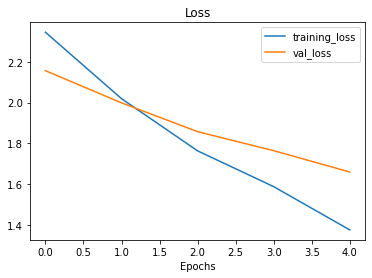

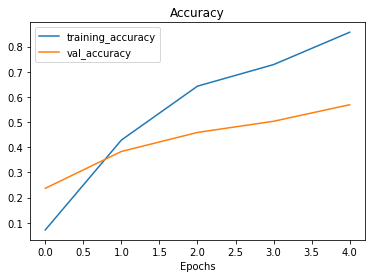

In [79]:
plot_loss_curves(history_1)